# Fine-tuning Qwen2 VL on Darija Visual Question Answering (VQA) Task
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/1337-Artificial-Intelligence/hackai-2025/blob/main/new_notebooks/vlm_finetune.ipynb)

As you learned in the [VLM Usage notebook](https://colab.research.google.com/github/Khadija-Bayoud/hackai-2025/blob/main/new_notebooks/vlm_usage.ipynb)
, Vision-Language Models (VLMs) are type of models that can understand both images and text and perform various tasks, one of which is Visual Question Answering (VQA). However, they may struggle to understand the nuances of the Darija dialect.
In this notebook, we will fine-tune a VLM to better understand and respond to questions in Darija.

## 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀


In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

Authenticate with your Hugging Face account to save and share your model directly from this notebook 🗝️.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load Model


Next, we’ll load the model and the tokenizer to prepare for finetuning/inference.

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.5.6: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

We can finetune ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

## 3. Load Dataset 📁

We’ll load the [Darija-VLM-Dataset](https://huggingface.co/datasets/HackAI-2025/Darija-VLM-Dataset) dataset, which provides images along with corresponding questions and answers for fine-tuning visual question-answering models.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("HackAI-2025/darija-vlm-dataset", split = "train")

README.md:   0%|          | 0.00/403 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1878 [00:00<?, ? examples/s]

Let's take an overview look at the dataset. We shall see what the 2nd image is, and what caption it had.

In [ ]:
dataset

Dataset({
    features: ['image', 'question', 'answer', 'source'],
    num_rows: 1878
})

Question:  شنو هاد البلاصة اللي فيها هاد التصويرة و شنو كيديرو فيها؟
Answer:  هادي سميتها الدباغة، كاينة فمدينة فاس. هنا فين كيصبغو الجلود باش يصاوبو منهم الصبابط و الشكارة و بزاف ديال الحوايج.


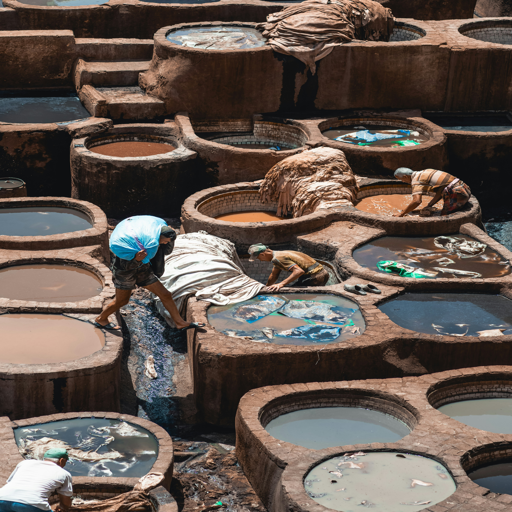

In [ ]:
print("Question: ", dataset[2]["question"])
print("Answer: ", dataset[2]["answer"])

dataset[2]["image"]

We will split the dataset into:
- Train : 80% to finetune the model
- Validation : 10% to validate the model during the finetuning
- Test : 10% to test the model after the finetuning

In [ ]:
train_valtest = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_ds = train_valtest["train"]
valtest_dataset = train_valtest["test"]

val_test = valtest_dataset.train_test_split(test_size=0.5, seed=42, shuffle=True)
val_ds = val_test["train"]
test_ds = val_test["test"]

print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 1502
Validation dataset size: 188
Test dataset size: 188


We’ll format the dataset into a chatbot structure, with the system message, image, user query, and answer for each interaction.

```python
[
{
"role": "system",
"content": [{"type": "text", "text": system_message}]
}
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [ ]:
system_message = """You are a Vision Language Model (VLM), designed to understand, describe, and explain everything that appears in images.
Your job is to extract meaningful information from what you see, and provide clear and contextually relevant answers, in Moroccan Darija."""

def convert_to_conversation(sample):
    conversation = [
        {
          "role": "system",
          "content": [{"type": "text", "text": system_message}]
        },
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : sample['question']},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["answer"]} ]
        },
    ]
    return { "messages" : conversation }

Now, let’s format the data using the chatbot structure. This will set up the interactions for the model.

In [ ]:
train_dataset = [convert_to_conversation(sample) for sample in train_ds]
val_dataset = [convert_to_conversation(sample) for sample in val_ds]
test_dataset = [convert_to_conversation(sample) for sample in test_ds]

First, let’s inspect the internal structure of the dataset after formating it to understand how it is organized and visualize some examples of images, questions and their corresponding answers.

In [ ]:
train_dataset[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a Vision Language Model (VLM), designed to understand, describe, and explain everything that appears in images.\nYour job is to extract meaningful information from what you see, and provide clear and contextually relevant answers, in Moroccan Darija.'}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': 'شنو كنشوفو قدام الطوموبيل ف هاد التصويرة؟'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'كنشوفو شي جمال كياكلو حدا البحر، وكنبانو بحال إلى حنا مسافرين فشي طريق قريبة للبحر.'}]}]}

## 4. Assess the VLM Performance before Finetuning

Now that we have loaded the model and the dataset, let's first test the VLM to see its performance before fine-tuning.
We will define a function that will handle the inference.

In [ ]:
def inference(model, tokenizer, messages, image):
  FastVisionModel.for_inference(model) # Enable for inference!

  input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
  inputs = tokenizer(
      image,
      input_text,
      add_special_tokens = False,
      return_tensors = "pt",
  ).to("cuda")

  from transformers import TextStreamer
  text_streamer = TextStreamer(tokenizer, skip_prompt = True)
  _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                    use_cache = True, temperature = 1.5, min_p = 0.1)

In [ ]:
test_index = 34
messages = test_dataset[test_index]['messages'][0:2]
image = messages[1]['content'][1]['image']

question = test_dataset[test_index]['messages'][0:2][1]['content'][0]['text']
ground_truth = test_dataset[test_index]['messages'][2]['content'][0]['text']

print("Question: ", question)
print("Original Answer: ", ground_truth)
print("Model Answer: ")

inference(model, tokenizer, messages, image)

Question:   شنو كنشوفو ف هاد التصويرة، واش شي بناية ولا شنو؟
Original Answer:  كنشوفو جزء من شي بناية كبيرة، يمكن تكون شركة ولا مكتب، و عندها واحد الديكور بحال الشبكة على برا.
Model Answer: 
ف العکس وچ قاعده بناء نیست که رو به چمن درآمد. تو آنجا اکنون سکونتگاه جهان موزه ویزای گلدن ریتر واقعی های زندگی است. دیوارهای لایه‌لایه یا فرایین زمینه با فراوانی موجی هستند که اما نه ساختمان هم، بلکه دو طبقه نیاز برای


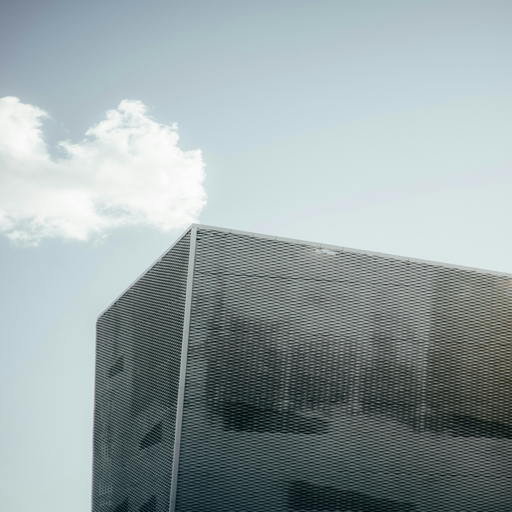

In [ ]:
image

The model mentions general architectural terms like "بناء" hinting at some visual cue recognition.

❌ Key Issues:
- Incoherent: Ends with nonsensical, hallucinated phrases.

- Irrelevant: Doesn’t clearly answer if it’s a building.

- Poor Darija Fluency: Awkward and unnatural phrasing.

- No Ground Truth Match: Misses key details like large building, office/company, and mesh decoration.

➡️ Conclusion: Fine-tuning is essential to improve relevance, coherence, and Darija understanding.

<a name="Train"></a>
##5. Train the model
We will use Supervised Fine-Tuning (SFT) to improve our model's performance on the VQA task. To achieve this, we'll define the training arguments with the [SFTConfig](https://huggingface.co/docs/trl/sft_trainer) class from the [TRL library](https://huggingface.co/docs/trl/index). SFT leverages labeled data to help the model generate more accurate responses, adapting it to the task. This approach enhances the model's ability to understand and respond to visual queries more effectively.

We use `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

# num_steps = (len(train_dataset) // batch_size) * epochs

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args = SFTConfig(
        output_dir="Qwen2-VL-7B-Instruct-Darija-VQA",
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        # max_steps = 50,
        num_train_epochs=3, # Set this instead of max_steps for full training runs
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=10,
        eval_steps=100,
        eval_strategy="steps",
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        report_to="wandb",     # For Weights and Biases
        push_to_hub=True,
        hub_model_id="username/Qwen2-VL-7B-Instruct-Darija-VQA",
        hub_token="",
        hub_strategy="all_checkpoints",

        # You MUST put the below items for vision finetuning:
        remove_unused_columns=False,
        dataset_text_field="answer",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
7.111 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,502 | Num Epochs = 3 | Total steps = 561
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,521,536/7,000,000,000 (0.74% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: khadijabayoud-me (khadijabayoud-me-toumai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
100,1.031700,0.928547
200,0.651800,0.835467
300,0.656600,0.803658
400,0.488500,0.803888
500,0.480400,0.790850


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


## 6. Testing the Fine-Tuned Model 🔍

Now that our Vision Language Model (VLM) is fine-tuned, it's time to evaluate its performance! In this section, we'll test the model using examples from the Darija VQA test dataset to assess how accurately it answers questions based on the images. Let's dive into the results and see how well it performs! 🚀

In [ ]:
test_index = 34
messages = test_dataset[test_index]['messages'][0:2]
image = messages[1]['content'][1]['image']

question = test_dataset[test_index]['messages'][0:2][1]['content'][0]['text']
ground_truth = test_dataset[test_index]['messages'][2]['content'][0]['text']

print("Question: ", question)
print("Original Answer: ", ground_truth)
print("Model Answer: ")

inference(model, tokenizer, messages, image)

Question:   شنو كنشوفو ف هاد التصويرة، واش شي بناية ولا شنو؟
Original Answer:  كنشوفو جزء من شي بناية كبيرة، يمكن تكون شركة ولا مكتب، و عندها واحد الديكور بحال الشبكة على برا.
Model Answer: 
كنشوفو ف هاد التصويرة جوج طوابق ديال شي بناية كبيرة على ما كتبين باللي، و السما فيها شوية ديال الغمام.<|im_end|>


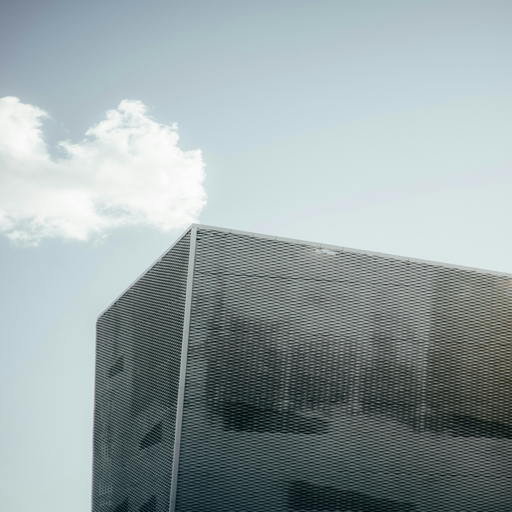

In [ ]:
image

We now observe that the VLM correctly recognizes the question is in Darija and responds in the same language. It also directly answers the question instead of providing generic information.

Challenge the model with your own images and questions — see what it can do! 🔥🤖✨

<a name="Save"></a>
## 7. Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model.

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
model.push_to_hub("username/lora_model", token = "")
tokenizer.push_to_hub("username/lora_model", token = "")

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/206M [00:00<?, ?B/s]

Saved model to https://huggingface.co/KBayoud/Qwen2-VL-7B-Instruct-Darija-VQA


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

test_index = 50
messages = test_dataset[test_index]['messages'][0:2]
image = messages[1]['content'][1]['image']

question = test_dataset[test_index]['messages'][0:2][1]['content'][0]['text']
ground_truth = test_dataset[test_index]['messages'][2]['content'][0]['text']

print("Question: ", question)
print("Original Answer: ", ground_truth)
print("Model Answer: ")

inference(model, tokenizer, messages, image)

##**🎓 Mabrouk 3lik! 🧠**

You've just completed the challenge of fine-tuning a Vision-Language Model for Visual Question Answering in Darija — well done!

🚀 This is a big step toward building inclusive AI that understands and serves local languages.

**❤️ Thank you for being part of this challenge.**
___